In [1]:
# Cell 1 — imports & plotting defaults
import pandas as pd
import numpy as np
from pathlib import Path
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Try Plotly for interactive charts; fallback if missing
try:
    import plotly.graph_objects as go
    import plotly.express as px
    PLOTLY = True
except Exception:
    PLOTLY = False

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (14,5)
sns.set_context("notebook")


In [2]:
# Cell 2 — load SILVER csv and parse datetimes robustly
DATA_PATH = Path("Data/SILVER_FUT.csv")
if not DATA_PATH.exists():
    raise FileNotFoundError(f"{DATA_PATH} not found. Put SILVER_FUT.csv in Data/")

df = pd.read_csv(DATA_PATH, dtype=str)
df.columns = [c.strip() for c in df.columns]

# normalize whitespace and parse datetime (dayfirst)
df['datetime_raw'] = df['datetime'].astype(str).str.replace(r'\s+', ' ', regex=True).str.strip()
df['datetime'] = pd.to_datetime(df['datetime_raw'], dayfirst=True, errors='coerce')

# numeric cast (future-proof: coerce invalid -> NaN)
for col in ['open','high','low','close','volume']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("Rows loaded:", len(df))
print("Datetime parse failures (NaT):", df['datetime'].isna().sum())
df.head(5)


Rows loaded: 547846
Datetime parse failures (NaT): 331081


,datetime,tradingsymbol,expiry,open,high,low,close,volume,datetime_raw
0,2021-01-07 09:31:00,SILVER21JULFUT,2021-07-05,68633.0,68633.0,68633.0,68633.0,0.0,2021-07-01 09:31:00
1,2021-01-07 09:32:00,SILVER21JULFUT,2021-07-05,68633.0,68633.0,68633.0,68633.0,0.0,2021-07-01 09:32:00
2,2021-01-07 09:33:00,SILVER21JULFUT,2021-07-05,68633.0,68633.0,68633.0,68633.0,0.0,2021-07-01 09:33:00
3,2021-01-07 09:34:00,SILVER21JULFUT,2021-07-05,68633.0,68633.0,68633.0,68633.0,0.0,2021-07-01 09:34:00
4,2021-01-07 09:35:00,SILVER21JULFUT,2021-07-05,68633.0,68633.0,68633.0,68633.0,0.0,2021-07-01 09:35:00


In [3]:
# Cell 3 — extract EOD per calendar date (cutoff 23:59 for commodity futures)
EOD_CUTOFF = "23:59"   # adjust if your exchange uses another cutoff

df = df.dropna(subset=['datetime']).copy()
df['sec_of_day'] = df['datetime'].dt.hour*3600 + df['datetime'].dt.minute*60 + df['datetime'].dt.second
df['cal_date'] = df['datetime'].dt.date

hh, mm = map(int, EOD_CUTOFF.split(':'))
cutoff_sec = hh*3600 + mm*60

df['market_date'] = pd.to_datetime(df['cal_date'])
after_mask = df['sec_of_day'] > cutoff_sec
df.loc[after_mask, 'market_date'] = df.loc[after_mask, 'market_date'] + pd.Timedelta(days=1)

df['eod_cutoff_ts'] = df['market_date'] + pd.to_timedelta(f"{EOD_CUTOFF}:00")
valid = df[df['datetime'] <= df['eod_cutoff_ts']].copy()
if valid.empty:
    raise ValueError("No valid ticks <= cutoff. Check timestamps/cutoff.")

idx = valid.groupby('market_date')['datetime'].idxmax()
eod = valid.loc[idx, ['market_date','datetime','open','high','low','close','volume','tradingsymbol']].copy()
eod['date'] = eod['market_date'].dt.date
eod = eod.sort_values('date').reset_index(drop=True)

print("EOD rows:", len(eod))
eod.head()


EOD rows: 260


,market_date,datetime,open,high,low,close,volume,tradingsymbol,date
0,2021-01-07,2021-01-07 23:29:00,68141.0,68141.0,68141.0,68141.0,0.0,SILVER21JULFUT,2021-01-07
1,2021-01-09,2021-01-09 23:29:00,63633.0,63633.0,63633.0,63633.0,0.0,SILVER21SEPFUT,2021-01-09
2,2021-01-10,2021-01-10 23:29:00,60530.0,60530.0,60507.0,60525.0,17.0,SILVER21DECFUT,2021-01-10
3,2021-01-11,2021-01-11 23:29:00,64795.0,64795.0,64770.0,64770.0,20.0,SILVER21DECFUT,2021-01-11
4,2021-01-12,2021-01-12 23:54:00,60772.0,60772.0,60772.0,60772.0,0.0,SILVER21DECFUT,2021-01-12


In [4]:
# Cell 4 — build a daily series (calendar index) and compute indicators
series = eod[['date','open','high','low','close','volume']].copy()
series['date'] = pd.to_datetime(series['date'])
series = series.set_index('date').asfreq('D')   # calendar index for smooth visuals

# numeric cleanup + forward-fill small gaps for visuals
for col in ['open','high','low','close']:
    series[col] = pd.to_numeric(series[col], errors='coerce').ffill()
series['volume'] = pd.to_numeric(series['volume'], errors='coerce').fillna(0)

# indicators
series['ma10'] = series['close'].rolling(10).mean()
series['ma50'] = series['close'].rolling(50).mean()
series['returns'] = series['close'].pct_change()
series['vol_14'] = series['returns'].rolling(14).std() * math.sqrt(252)

# Bollinger Bands (20)
series['ma20'] = series['close'].rolling(20).mean()
series['std20'] = series['close'].rolling(20).std()
series['bb_up'] = series['ma20'] + 2*series['std20']
series['bb_dn'] = series['ma20'] - 2*series['std20']

# RSI (14)
delta = series['close'].diff()
up = delta.clip(lower=0)
down = -1 * delta.clip(upper=0)
roll_up = up.ewm(com=14-1, adjust=False).mean()
roll_down = down.ewm(com=14-1, adjust=False).mean()
rs = roll_up / roll_down
series['rsi_14'] = 100 - (100.0 / (1.0 + rs))

series.tail(6)


,open,high,low,close,volume,ma10,ma50,returns,vol_14,ma20,std20,bb_up,bb_dn,rsi_14
date,,,,,,,,,,,,,,
2025-01-27,87550.0,87550.0,87550.0,87550.0,0.0,87550.0,89535.0,0.000000,0.000000,87550.00,0.000000,87550.000000,87550.000000,34.229954
2025-01-28,87550.0,87550.0,87550.0,87550.0,0.0,87550.0,89544.0,0.000000,0.000000,87550.00,0.000000,87550.000000,87550.000000,34.229954
2025-01-29,87550.0,87550.0,87550.0,87550.0,0.0,87550.0,89553.0,0.000000,0.000000,87550.00,0.000000,87550.000000,87550.000000,34.229954
2025-01-30,87550.0,87550.0,87550.0,87550.0,0.0,87550.0,89562.0,0.000000,0.000000,87550.00,0.000000,87550.000000,87550.000000,34.229954
2025-01-31,87550.0,87550.0,87550.0,87550.0,0.0,87550.0,89461.4,0.000000,0.000000,87550.00,0.000000,87550.000000,87550.000000,34.229954
2025-02-01,89124.0,89129.0,89025.0,89025.0,28.0,87697.5,89390.3,0.016848,0.071478,87623.75,329.820027,88283.390053,86964.109947,69.336595


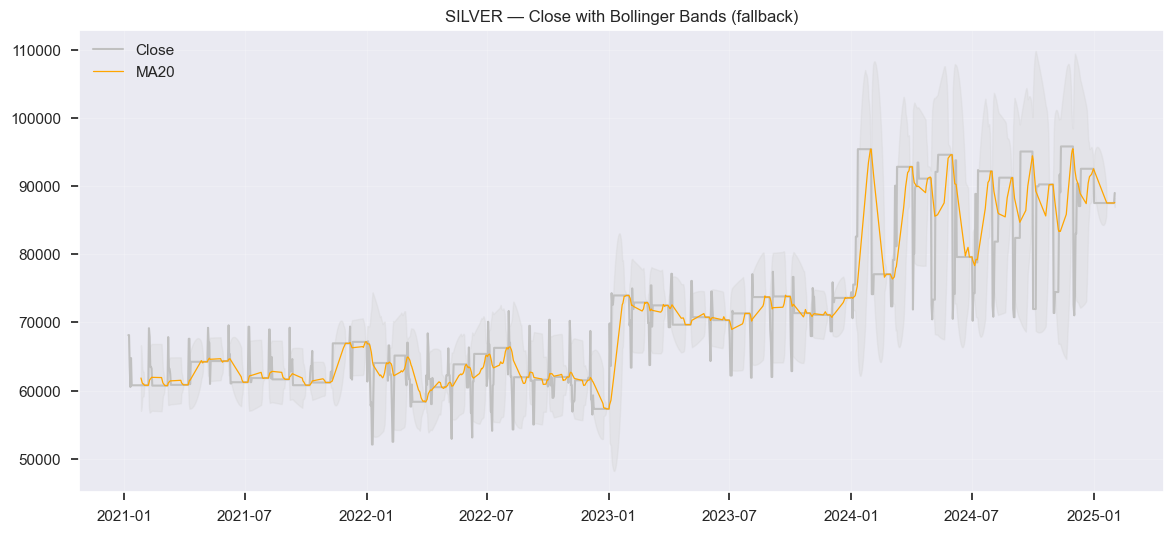

In [5]:
# Cell 5 — Candlestick + Bollinger (interactive if available)
if PLOTLY:
    fig = go.Figure()
    fig.add_trace(go.Candlestick(x=series.index,
                                 open=series['open'], high=series['high'],
                                 low=series['low'], close=series['close'],
                                 name='OHLC'))
    fig.add_trace(go.Scatter(x=series.index, y=series['ma20'], name='MA20', line=dict(color='orange', width=1)))
    fig.add_trace(go.Scatter(x=series.index, y=series['bb_up'], name='BB Up', line=dict(width=1), opacity=0.6))
    fig.add_trace(go.Scatter(x=series.index, y=series['bb_dn'], name='BB Down', line=dict(width=1), opacity=0.6))
    fig.update_layout(title='SILVER — Candlestick with Bollinger Bands', xaxis_title='Date', yaxis_title='Price', height=600)
    fig.show()
else:
    plt.figure(figsize=(14,6))
    plt.plot(series.index, series['close'], label='Close', color='silver')
    plt.plot(series.index, series['ma20'], label='MA20', color='orange', linewidth=0.9)
    plt.fill_between(series.index, series['bb_up'], series['bb_dn'], color='lightgray', alpha=0.3)
    plt.title('SILVER — Close with Bollinger Bands (fallback)')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()


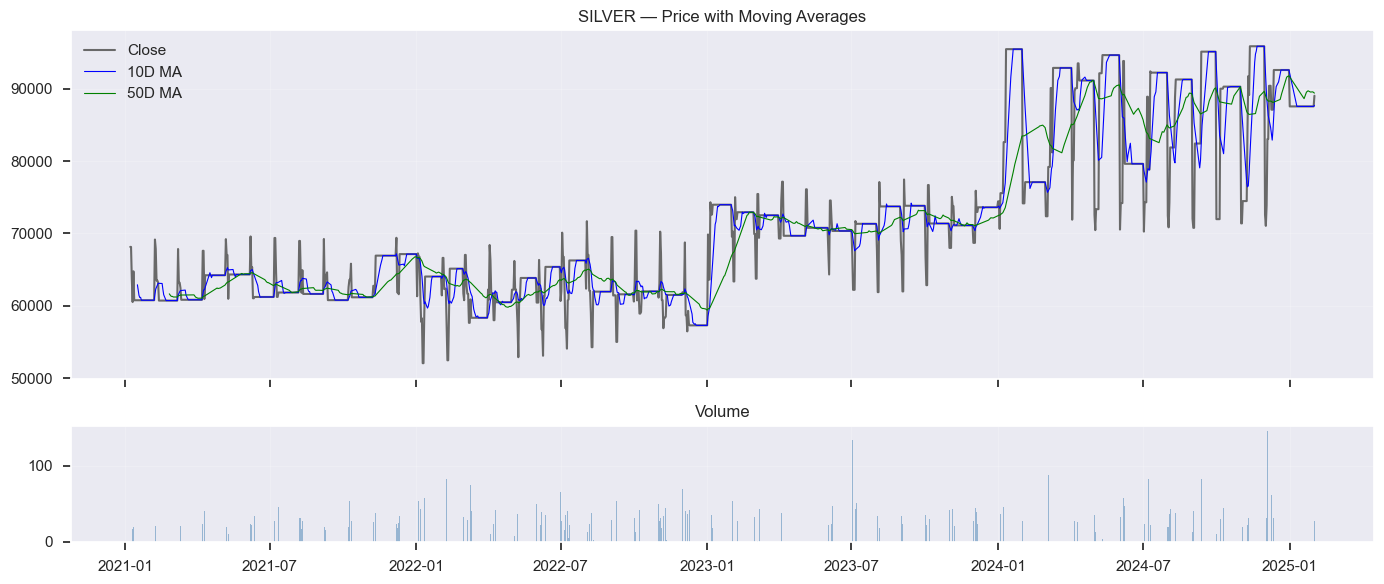

In [6]:
# Cell 6 — Price (line) with volume bars underneath
fig, ax = plt.subplots(2,1, figsize=(14,6), gridspec_kw={'height_ratios':[3,1]}, sharex=True)
ax[0].plot(series.index, series['close'], label='Close', color='dimgray')
ax[0].plot(series.index, series['ma10'], label='10D MA', color='blue', linewidth=0.8)
ax[0].plot(series.index, series['ma50'], label='50D MA', color='green', linewidth=0.8)
ax[0].set_title('SILVER — Price with Moving Averages')
ax[0].legend(); ax[0].grid(alpha=0.2)

ax[1].bar(series.index, series['volume'], color='steelblue', alpha=0.5)
ax[1].set_title('Volume')
ax[1].grid(alpha=0.2)
plt.tight_layout()
plt.show()


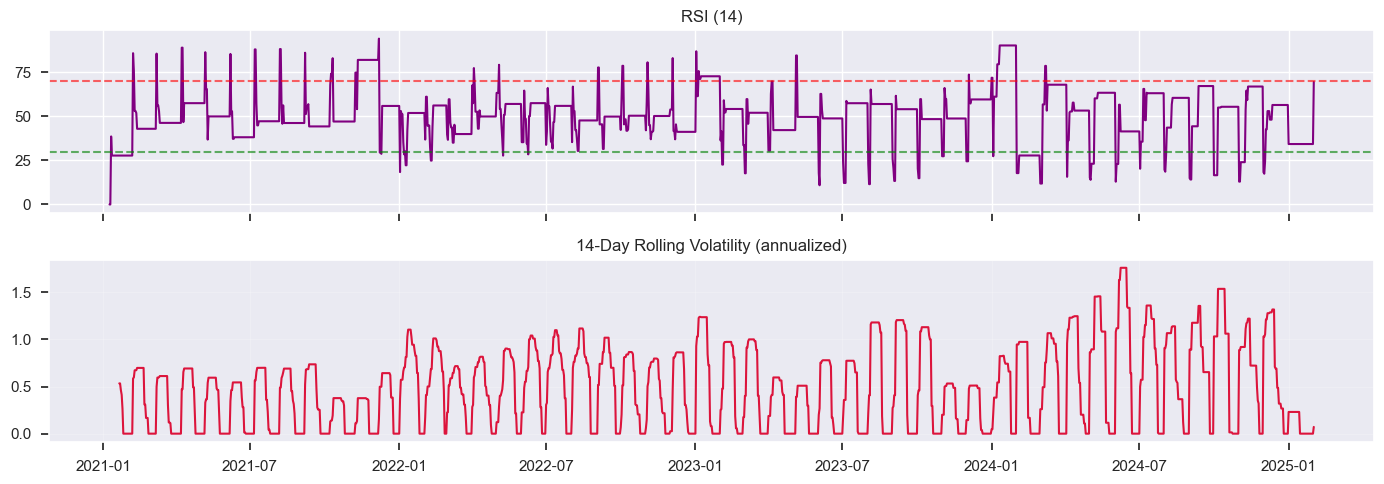

In [7]:
# Cell 7 — RSI and Volatility
fig, axes = plt.subplots(2,1, figsize=(14,5), sharex=True)
axes[0].plot(series.index, series['rsi_14'], color='purple')
axes[0].axhline(70, color='red', linestyle='--', alpha=0.6)
axes[0].axhline(30, color='green', linestyle='--', alpha=0.6)
axes[0].set_title('RSI (14)')

axes[1].plot(series.index, series['vol_14'], color='crimson')
axes[1].set_title('14-Day Rolling Volatility (annualized)')
axes[1].grid(alpha=0.2)

plt.tight_layout()
plt.show()


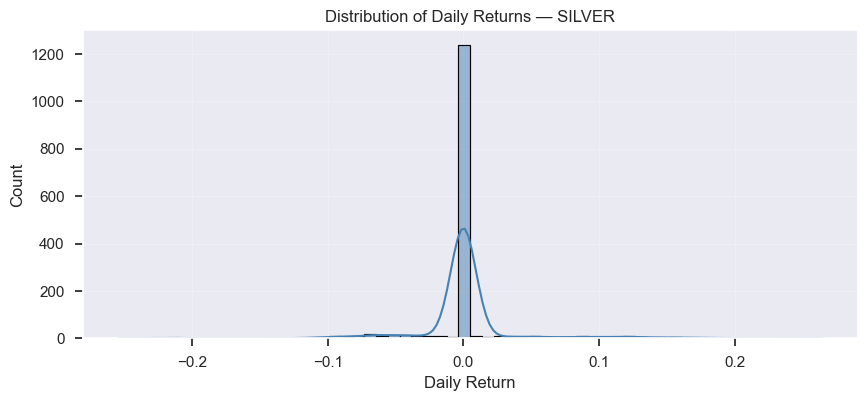

In [9]:
# Cell 8 — distribution of daily returns and monthly boxplot (seasonality)
ret = series['returns'].dropna()

plt.figure(figsize=(10,4))
sns.histplot(ret, bins=60, kde=True, color='steelblue')
plt.title('Distribution of Daily Returns — SILVER')
plt.xlabel('Daily Return')
plt.grid(alpha=0.2)
plt.show()

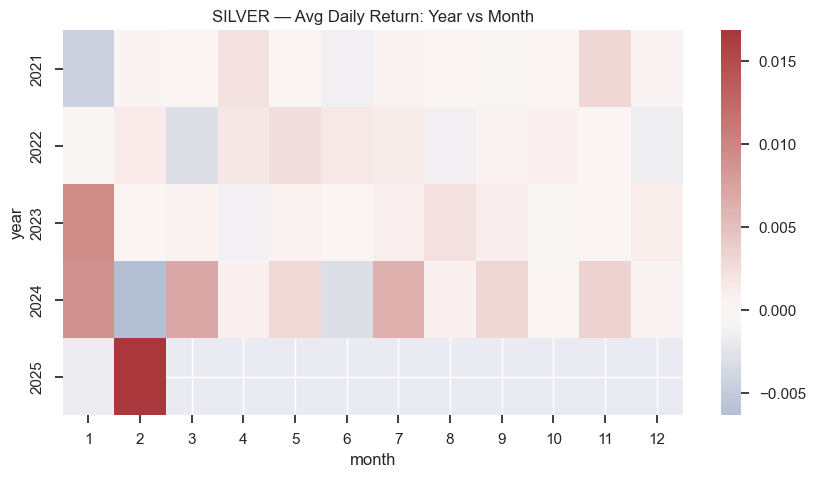

In [10]:
# Cell 9 — seasonality heatmap (avg daily return per (year, month))
dfh = series['returns'].dropna().to_frame()
dfh['year'] = dfh.index.year
dfh['month'] = dfh.index.month
pivot = dfh.pivot_table(values='returns', index='year', columns='month', aggfunc='mean')
plt.figure(figsize=(10,5))
sns.heatmap(pivot, cmap='vlag', center=0, annot=False)
plt.title('SILVER — Avg Daily Return: Year vs Month')
plt.show()


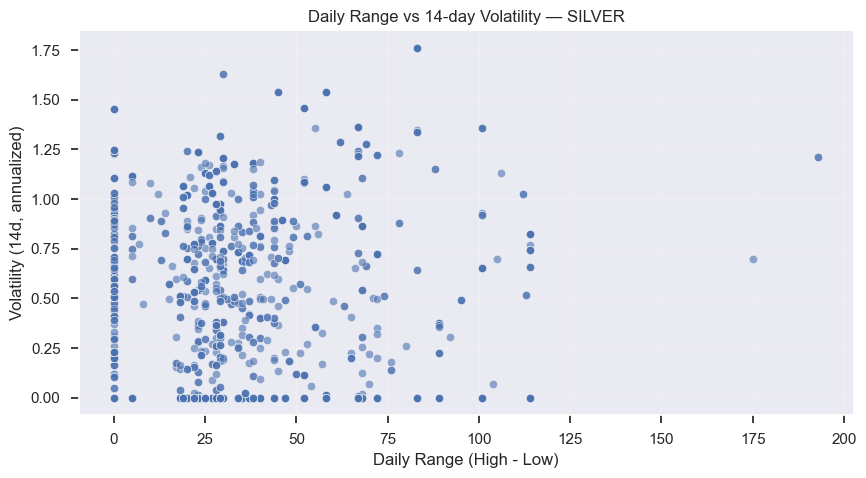

In [11]:
# Cell 10 — daily range vs volatility scatter (range = high-low)
series['range'] = (series['high'] - series['low']).abs()
plt.figure(figsize=(10,5))
sns.scatterplot(x='range', y='vol_14', data=series.dropna(subset=['range','vol_14']), alpha=0.6)
plt.title('Daily Range vs 14-day Volatility — SILVER')
plt.xlabel('Daily Range (High - Low)')
plt.ylabel('Volatility (14d, annualized)')
plt.grid(alpha=0.2)
plt.show()


In [12]:
# Cell 11 — summary metrics for display
latest = series['close'].dropna().iloc[-1]
period_change_pct = (series['close'].dropna().iloc[-1] / series['close'].dropna().iloc[0] - 1.0) * 100
recent_vol = series['vol_14'].dropna().iloc[-1] if series['vol_14'].dropna().size else np.nan

print("SILVER Snapshot")
print("Latest price:", round(latest,2))
print("Total period change:", f"{period_change_pct:.2f}%")
print("Recent vol (14d, annualized):", round(recent_vol,3))


SILVER Snapshot
Latest price: 89025.0
Total period change: 30.65%
Recent vol (14d, annualized): 0.071


In [13]:
# Cell 12 — optional baseline (lightweight)
try:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    df_tab = series[['close']].copy().reset_index().rename(columns={'index':'date'})
    for lag in range(1,6):
        df_tab[f'lag_{lag}'] = df_tab['close'].shift(lag)
    df_tab = df_tab.dropna().reset_index(drop=True)

    X = df_tab[[f'lag_{l}' for l in range(1,6)]].values
    y = df_tab['close'].shift(-1).ffill().values

    if len(X) < 50:
        print("Not enough rows for baseline demo; skipping.")
    else:
        split = int(0.8 * len(X))
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        mae = mean_absolute_error(y_test, preds)
        rmse = (mean_squared_error(y_test, preds))**0.5
        print("Baseline (5-lag) MAE:", round(mae,2))
        print("Baseline (5-lag) RMSE:", round(rmse,2))
except Exception as ex:
    print("Baseline skipped (sklearn missing or error):", ex)


Baseline (5-lag) MAE: 4826.21
Baseline (5-lag) RMSE: 7079.08


In [14]:
# Cell 13 — final note for embedding
print("SILVER showcase ready.")
print("Export to HTML for embedding:")
print("jupyter nbconvert --to html SILVER_showcase.ipynb --output public/notebooks/silver_showcase.html")


SILVER showcase ready.
Export to HTML for embedding:
jupyter nbconvert --to html SILVER_showcase.ipynb --output public/notebooks/silver_showcase.html
